In [158]:
import pickle
import numpy as np
import rewardpredictive as rp
import rlutils as rl
import matplotlib.pyplot as plt
from pathlib import Path
from rewardpredictive.mdp import RandomRewardChange, mdp_goal_dist

from matplotlib import rc
rc('font', **{'family': 'serif', 'size': 9})
rc('text', usetex=True)

from definitions import ROOT_DIR

results_directory = 'UniformRandomResults'
maze_file = Path(ROOT_DIR, 'data', 'RandomRewardMaze', 'maze.pkl')

ql = rp.ExperimentSetTaskSequenceRandomRewardChangeQLearning.load(base_dir=f'./data/{results_directory}')
qt = rp.ExperimentSetTaskSequenceRandomRewardChangeQTransfer.load(base_dir=f'./data/{results_directory}')
sfl = rp.ExperimentSetTaskSequenceRandomRewardChangeSFLearning.load(base_dir=f'./data/{results_directory}')
sft = rp.ExperimentSetTaskSequenceRandomRewardChangeSFTransfer.load(base_dir=f'./data/{results_directory}') 
sfta = rp.ExperimentSetTaskSequenceRandomRewardChangeSFTransferAll.load(base_dir=f'./data/{results_directory}')

with open(maze_file, 'rb') as f:
    mdp_seq = pickle.load(f)

In [159]:
all_positions = [mdp_seq[0].goal_position]
all_distances = [0]
for i in range(1, len(mdp_seq)):
    all_distances.append(int(mdp_goal_dist(mdp_seq[i-1], mdp_seq[i])))
    all_positions.append(mdp_seq[i].goal_position)
len(all_distances)

AttributeError: 'RandomRewardChange' object has no attribute 'goal_position'

In [153]:
# Set up some preliminary variables used for plotting
episodes_per_task = ql.experiment_list[0].hparam["episodes"]
runs_per_task = ql.experiment_list[0].hparam["repeats"]
ql.experiment_list[0]
num_tasks = ql.experiment_list[0].hparam["num_tasks"]
tasks = np.arange(num_tasks)


Q-learning
repeats: 10
task_sequence: significant
exploration: egreedy
episodes: 100
epsilon: 0.1
gamma: 0.9
mdp_size: 8
num_tasks: 20
lr: 0.7
Q-learning with Q-value transfer
repeats: 10
task_sequence: significant
exploration: egreedy
episodes: 100
epsilon: 0.1
gamma: 0.9
mdp_size: 8
num_tasks: 20
lr: 0.9
SF-transfer
repeats: 10
task_sequence: significant
exploration: egreedy
episodes: 100
epsilon: 0.1
gamma: 0.9
mdp_size: 8
num_tasks: 20
lr_sf: 0.3
lr_r: 0.7
SF-learning
repeats: 10
task_sequence: significant
exploration: egreedy
episodes: 100
epsilon: 0.1
gamma: 0.9
mdp_size: 8
num_tasks: 20
lr_sf: 0.9
lr_r: 0.9
SF-learning with SF and rew transfer
repeats: 10
task_sequence: significant
exploration: egreedy
episodes: 100
epsilon: 0.1
gamma: 0.9
mdp_size: 8
num_tasks: 20
lr_sf: 0.7
lr_r: 0.9


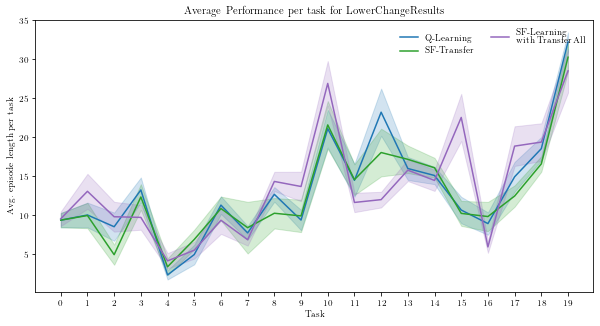

In [154]:
print('Q-learning')
exp_ql = ql.get_best_experiment(exploration='egreedy', task_sequence='significant') 
print('Q-learning with Q-value transfer')
exp_qt = qt.get_best_experiment(exploration='egreedy', task_sequence='significant')  
print('SF-transfer')
exp_sft = sft.get_best_experiment(exploration='egreedy', task_sequence='significant')  
print('SF-learning')
exp_sfl = sfl.get_best_experiment(exploration='egreedy', task_sequence='significant')  
print('SF-learning with SF and rew transfer')
exp_sfta = sfta.get_best_experiment(exploration='egreedy', task_sequence='significant')  

ep_len_qlearning = np.mean(np.array(exp_ql.results['episode_length'])[:, :, :50], axis=-1)
ep_len_qtransfer = np.mean(np.array(exp_qt.results['episode_length'])[:, :, :50], axis=-1)
ep_len_sftransfer = np.mean(np.array(exp_sft.results['episode_length'])[:, :, :50], axis=-1)
ep_len_sflearning = np.mean(np.array(exp_sfl.results['episode_length'])[:, :, :50], axis=-1)
ep_len_sftransferall = np.mean(np.array(exp_sfta.results['episode_length'])[:, :, :50], axis=-1)

plt.figure(figsize=(10, 5))
rl.plot.mean_with_sem(tasks, ep_len_qlearning, axis=0, color='C0', label='Q-Learning')
# rl.plot.mean_with_sem(tasks, ep_len_qtransfer, axis=0, color='C1', label='Q-Learning\nwith Transfer')
rl.plot.mean_with_sem(tasks, ep_len_sftransfer, axis=0, color='C2', label='SF-Transfer')
# rl.plot.mean_with_sem(tasks, ep_len_sflearning, axis=0, color='C3', label='SF-Learning')
rl.plot.mean_with_sem(tasks, ep_len_sftransferall, axis=0, color='C4', label='SF-Learning\nwith Transfer All')

# plt.ylim([10, 35])
plt.title(f'Average Performance per task for {results_directory}')
plt.ylabel('Avg. episode length per task')
plt.xlabel('Task')
plt.xticks(tasks)
leg = plt.legend(loc=1, ncol=2, frameon=False)
leg.get_frame().set_linewidth(0.0)
plt.savefig('figure/sftransfer/comparison_ep_len_per_task.pdf', bbox_inches='tight', pad_inches=.1, transparent=True)

In [155]:
np.array(exp_ql.results['episode_length']).shape

(10, 20, 100)

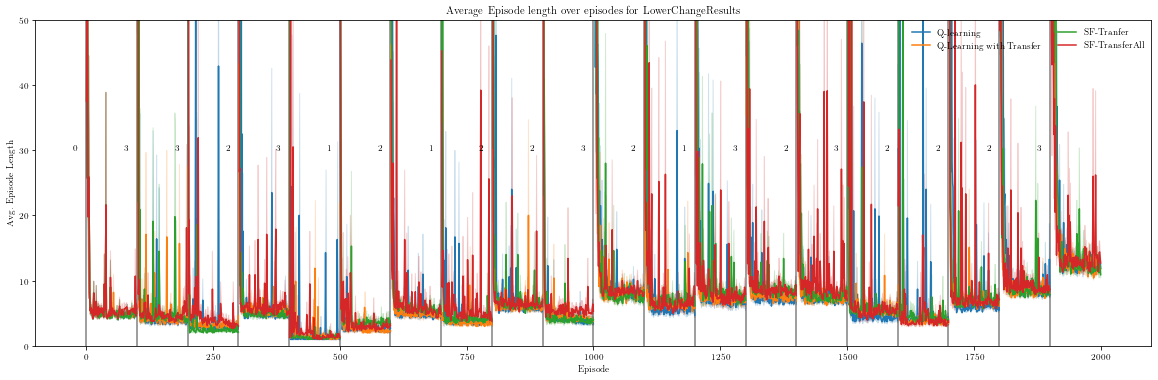

In [156]:
import numpy as np
from scipy.stats import sem

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

def mean_with_sem(xvals, yvals, axis=0, color='C0', label=None):  # pragma: no cover
    import matplotlib.pyplot as plt # Must be imported on use, otherwise matplotlib may open a UI window.

    yvals_m = np.mean(yvals, axis=axis)
#     yvals_m = smooth(yvals_m, 10)
    yvals_m = yvals_m

    yvals_e = sem(yvals, axis=axis)
    plt.plot(xvals, yvals_m, c=color, label=label)
    plt.fill_between(xvals, y1=yvals_m + yvals_e, y2=yvals_m - yvals_e, color=color, alpha=0.2)

y_lim = 50

plt.figure(figsize=(20, 6))
# i = 1
for i, j in [(episodes_per_task * task, task) for task in tasks]:
    plt.plot([i, i], [0, 1000], c='k', alpha=0.5)
    plt.text(i - 25, y_lim - 20, all_distances[j])
# plt.plot([i, i], [0, 1000], c='k', alpha=0.5)
# plt.text(i - 15, y_lim - 2, all_distances[j])
ep_len_ql = np.array(exp_ql.results['episode_length']).transpose([1, 0, 2])
ep_len_qt = np.array(exp_qt.results['episode_length']).transpose([1, 0, 2])
ep_len_sfl = np.array(exp_sfl.results['episode_length']).transpose([1, 0, 2])
ep_len_sft = np.array(exp_sft.results['episode_length']).transpose([1, 0, 2])
ep_len_sfta = np.array(exp_sfta.results['episode_length']).transpose([1, 0, 2])
ep_idx = np.arange(100) + 1
# exp_names = ["Q-learning", "Q-Learning with Transfer", "SF-Learning", "SF-Tranfer", "SF-TransferAll"]
# for j, ep in enumerate([ep_len_ql, ep_len_qt, ep_len_sfl, ep_len_sft, ep_len_sfta]):
exp_names = ["Q-learning", "Q-Learning with Transfer", "SF-Tranfer", "SF-TransferAll"]
for j, ep in enumerate([ep_len_ql, ep_len_qt, ep_len_sft, ep_len_sfta]):
    for i, ep_len in enumerate(ep):
        mean_with_sem(ep_idx + i * 100, ep_len, axis=0, color=f'C{j}', label=exp_names[j] if i == 0 else "")
    
#     mean_with_sem(ep_idx + i * 100, ep[i], axis=0, color=f'C{j}', label=exp_names[j])

# plt.xticks([0] + list(np.arange(episodes_per_task, (episodes_per_task * num_tasks + 1), episodes_per_task)))
plt.xlabel('Episode')
plt.ylabel('Avg. Episode Length')
plt.ylim([0, y_lim])
plt.title(f'Average Episode length over episodes for {results_directory}')
leg = plt.legend(loc=1, ncol=2, frameon=False)
leg.get_frame().set_linewidth(0.0)
plt.savefig('figure/sftransfer/sf_transfer_ep_len.pdf', bbox_inches='tight', pad_inches=.1, transparent=True)

In [157]:
{
    "Q-Learning": ep_len_qlearning.mean(),
    "Q-Transfer": ep_len_qtransfer.mean(),
    "SF-Transfer": ep_len_sftransfer.mean(),
    "SF-Learning": ep_len_sflearning.mean(),
    "SF-TransferAll": ep_len_sftransferall.mean()
}

{'Q-Learning': 13.2074,
 'Q-Transfer': 18.8706,
 'SF-Transfer': 12.626199999999999,
 'SF-Learning': 12.6654,
 'SF-TransferAll': 13.5744}

In [11]:
ep_len_qlearning

array([[ 5.65,  5.85,  2.48, 12.06,  1.15,  2.73,  7.85,  7.95,  8.43,
         8.82, 12.9 , 18.92, 26.66,  8.2 , 11.57,  8.94,  4.2 , 15.54,
        11.94, 23.2 ],
       [ 5.19,  6.97,  5.21,  8.94,  1.38,  4.04,  8.97,  5.19, 11.55,
         7.66, 11.3 ,  7.9 , 20.11,  8.94, 12.65,  4.22,  8.06, 14.3 ,
        16.97, 22.79],
       [ 8.27,  4.49,  2.92, 10.26,  1.26,  2.5 ,  8.52,  3.55, 10.25,
         3.72, 17.15,  6.35,  9.  , 15.08,  9.51,  4.42,  6.31,  7.73,
        13.23, 25.73],
       [ 6.8 , 10.08, 11.21,  5.28,  1.28,  2.42,  5.81,  4.57, 11.83,
         3.73, 13.28,  8.64, 14.14, 11.09,  9.37,  9.17,  7.39,  9.28,
         9.05, 21.08],
       [ 7.2 ,  4.72,  4.03,  6.88,  1.14,  7.85,  6.3 ,  5.35,  9.68,
         6.84, 21.36, 12.51,  8.86, 14.29,  8.91,  7.12,  7.12, 14.98,
        16.92, 22.51],
       [ 6.06, 12.92,  5.33, 11.25,  3.43,  2.68, 11.87,  4.94,  8.47,
         6.13, 12.57,  7.8 , 13.89, 11.45, 10.98, 12.05,  4.28, 11.79,
        12.87, 20.3 ],
       [ 9

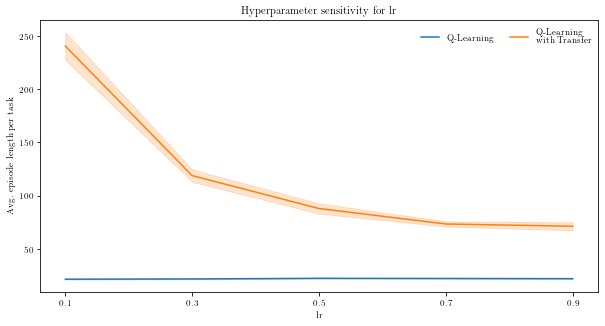

In [76]:
# HYPERPARAMETER SENSITIVITY PLOTSplt.figure(figsize=(10, 5))
hyperparam = "lr"

def get_hp_results(exp_set, hyperparam):
    variants = []
    full_results = []
    averages = []
    for exp in exp_set.experiment_list:
        variants.append(exp.hparam[hyperparam])
        data = np.array(exp.results['episode_length'])
        full_results.append(data)
        averages.append(np.average(data, axis=(-2, -1)))
    
    return variants, averages, full_results

variants, ql_averages, _ = get_hp_results(ql, hyperparam)
_, qt_averages, _ = get_hp_results(qt, hyperparam)
# _, sft_averages, _ = get_hp_results(sft, hyperparam)
# _, sfl_averages, _ = get_hp_results(sfl, hyperparam)
# _, sfta_averages, _ = get_hp_results(sfta, hyperparam)


plt.figure(figsize=(10, 5))
rl.plot.mean_with_sem(variants, ql_averages, axis=1, color='C0', label='Q-Learning')
rl.plot.mean_with_sem(variants, qt_averages, axis=1, color='C1', label='Q-Learning\nwith Transfer')
# # rl.plot.mean_with_sem(variants, sft_averages, axis=0, color='C2', label='SF-Transfer')
# # rl.plot.mean_with_sem(variants, sfl_averages, axis=0, color='C3', label='SF-Learning')
# # rl.plot.mean_with_sem(variants, sfta_averages, axis=0, color='C4', label='SF-Learning\nwith Transfer All')

# plt.ylim([10, 35])
plt.title(f'Hyperparameter sensitivity for {hyperparam}')
plt.ylabel('Avg. episode length per task')
plt.xlabel(f'{hyperparam}')
plt.xticks(variants)
leg = plt.legend(loc=1, ncol=2, frameon=False)
leg.get_frame().set_linewidth(0.0)
plt.savefig('figure/sftransfer/hyperparam_sensitivity_ep_len_per_variant.pdf', bbox_inches='tight', pad_inches=.1, transparent=True)

In [109]:
hyperparam = "lr_r"

def get_grouped_hp_results(exp_set, hyperparam):
    full_results = {}
    grouped_averages = {}
    for exp in exp_set.experiment_list:
        hypp = exp.hparam[hyperparam]
        if hypp not in full_results:
            full_results[hypp] = []
            grouped_averages[hypp] = []
        data = np.array(exp.results['episode_length'])
        full_results[hypp].append(data)
        grouped_averages[hypp].append(np.average(data, axis=(-2, -1)))
    
    return full_results, grouped_averages

_, sft_averages = get_grouped_hp_results(sft, hyperparam)
_, sfl_averages, _ = get_grouped_hp_results(sfl, hyperparam)
_, sfta_averages, _ = get_grouped_hp_results(sfta, hyperparam)

rl.plot.mean_with_sem(list(sft_averages.keys()), list(sft_averages.values()), axis=1, color='C2', label='SF-Transfer')
# rl.plot.mean_with_sem(variants, sfl_averages, axis=1, color='C3', label='SF-Learning')
# rl.plot.mean_with_sem(variants, sfta_averages, axis=1, color='C4', label='SF-Learning\nwith Transfer All')

# plt.ylim([10, 35])
plt.title(f'Hyperparameter sensitivity for {hyperparam}')
plt.ylabel('Avg. episode length per task')
plt.xlabel(f'{hyperparam}')
plt.xticks(variants)
leg = plt.legend(loc=1, ncol=2, frameon=False)
leg.get_frame().set_linewidth(0.0)
plt.savefig('figure/sftransfer/hyperparam_sensitivity_ep_len_per_variant.pdf', bbox_inches='tight', pad_inches=.1, transparent=True)

ValueError: not enough values to unpack (expected 3, got 2)

[array([16.2525, 17.878 , 19.145 , 19.955 , 22.253 , 18.768 , 17.323 ,
        23.022 , 20.3835, 23.9795]),
 array([18.0955, 17.878 , 18.285 , 19.8285, 21.509 , 22.675 , 17.323 ,
        23.022 , 20.3835, 22.1675]),
 array([17.986 , 17.862 , 18.843 , 19.8285, 20.444 , 21.493 , 21.3855,
        18.8655, 19.9985, 21.5385]),
 array([17.986 , 18.829 , 19.1665, 19.8285, 19.955 , 18.8165, 21.3855,
        18.8655, 19.9985, 21.5385]),
 array([16.8855, 18.561 , 17.956 , 19.8285, 24.4895, 20.0275, 21.3855,
        18.8625, 19.643 , 21.5385]),
 array([21.7145, 17.333 , 23.487 , 18.7395, 17.018 , 20.2025, 21.0015,
        21.2775, 22.258 , 21.7275]),
 array([21.889 , 17.307 , 26.894 , 20.0445, 17.018 , 18.523 , 20.221 ,
        18.9825, 23.6195, 22.0605]),
 array([21.0175, 17.256 , 23.235 , 20.0445, 17.018 , 18.3495, 20.2225,
        18.8555, 19.9695, 23.464 ]),
 array([21.541 , 17.2525, 18.6545, 20.8695, 23.024 , 19.092 , 21.551 ,
        18.114 , 21.4215, 18.231 ]),
 array([21.736 , 19.88  , 23

In [78]:
sft.experiment_list[0].hparam

{'repeats': 10,
 'task_sequence': 'significant',
 'exploration': 'egreedy',
 'episodes': 100,
 'epsilon': 0.1,
 'gamma': 0.9,
 'mdp_size': 8,
 'num_tasks': 20,
 'lr_sf': 0.1,
 'lr_r': 0.1}